## Predicting Power Plant Output

The data used in this notebook consists of 9,568 observations, each with 4 environmental attributes collected from a __Combined Cycle Power Plant__ over 6 years (2006-2011), and is provided by the University of California, Irvine at [UCI Machine Learning Repository Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant).

The objective is to predict power output, a continuous variable. 

### All the necessary module imports:

In [1]:
import pandas as pd
import numpy as np
import requests 
from zipfile import ZipFile 
import io
import matplotlib.pyplot as plt
import matplotlib
import scipy
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor

matplotlib.style.use('ggplot')  # for ggplot style graphs 

### Extract-Transform-Load

#### Load the dataset from the UCI archive:
It's a zipped folder named _CCPP_ and contains the data in an excel file with a `.xlsx` format split into 5 sheets:

In [2]:
try:
    df = pd.read_csv('poweroutput.csv', index_col=0)  # Try to open the dataset saved in a .csv file
except FileNotFoundError:  # if it's not there get it from the UCI online repository 
    request = requests.get('https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip')
    zipfile = ZipFile(io.BytesIO(request.content))  # It's in a zipped folder, so need to unzip it
    with zipfile.open('CCPP/Folds5x2_pp.xlsx') as f:
        dict_df = pd.read_excel(f, sheetname=None)  # This returns a dictionary of DataFrame objects
        df = pd.concat(dict_df, ignore_index=1)  # Concatenate them and form a signle DataFrame
        df.to_csv('./poweroutput.csv')  # Save it for easier access later

Let's print out the shape of df to confirm everything is there. It should be 5 columns and 47,840 rows. We can check what type of object it is as well:

In [3]:
print(type(df))
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
(47840, 5)


Let's print out the top and bottom 5 observations:

In [4]:
print(df.head())
print()
print(df.tail())

      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

          AT      V       AP     RH      PE
47835  15.12  48.92  1011.80  72.93  462.59
47836  33.41  77.95  1010.30  59.72  432.90
47837  15.99  43.34  1014.20  78.66  465.96
47838  17.65  59.87  1018.58  94.65  450.93
47839  23.68  51.30  1011.86  71.24  451.67


Below we can see some descriptive information for the data:

In [5]:
df.describe()

,AT,V,AP,RH,PE
count,47840.000000,47840.000000,47840.000000,47840.000000,47840.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452162,12.707362,5.938535,14.599658,17.066281
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


Let's graph the __Power Output__ (__PE__), which we're trying to predict, against the predictors:

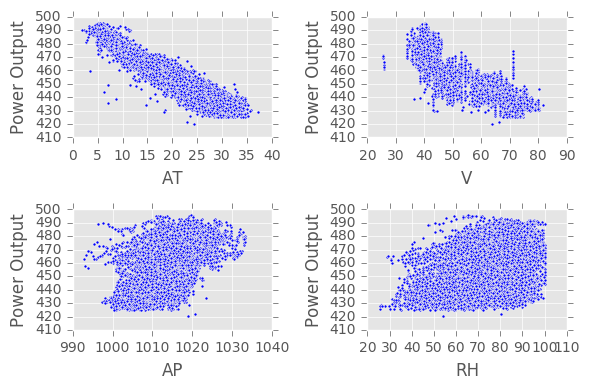

In [6]:
plt.clf()
plt.figure(1, figsize=(20, 27))
for subplot, col in zip(range(221, 225), df.columns):
    plt.subplot(subplot)
    plt.scatter(df[col], df['PE'], marker='.')
    plt.xlabel(col)
    plt.ylabel('Power Output')
plt.tight_layout()
plt.show()

From the graphs above, it looks like there's a linear relationship between __PE__ and __AT__, as well as __PE__ and __V__. There doesn't seem to be any linear relationship between __PE__ and the other two features.

## Splitting the dataset

We know that __PE__ is the dependent variable (y) and the first four columns contain the predictors.

Let's split the data into training and test sets. The training set will be used to train, tune and compare the model(s) using cross-validation and nested cross-validation, while the test set will be used to evaluate the performance of the final model with unseen data.

In [7]:
X, y = df.iloc[:,:4], df.iloc[:, -1:]
print(X.head())
print()
print(y.head())
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

      AT      V       AP     RH
0  14.96  41.76  1024.07  73.17
1  25.18  62.96  1020.04  59.08
2   5.11  39.40  1012.16  92.14
3  20.86  57.32  1010.24  76.64
4  10.82  37.50  1009.23  96.62

       PE
0  463.26
1  444.37
2  488.56
3  446.48
4  473.90


The dimensions of the training and test sets are as shown below:

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(38272, 4)
(9568, 4)
(38272, 1)
(9568, 1)


## Predictive analysis

I will compare three different models' performance: Linear Regression (OLS, Ridge and Lasso), Decision Tree and Random Forest. 

#### Linear Regression

Let's see how an OLS regression (without any regularization) would perform.
I use a pipeline to, first, standardize all the variables for a better model fit, and then to fit the Linear Regression model.
I calculate the Root Mean Squared Error (RMSE) and the R-Squared value as performance metrics. Since there are more than one predictors, it is wise to use the Adjusted R-squared value to evaluate the model performance instead of the (unadjusted) R-Squared.

In [9]:
def adjusted_r2(r2, n, p):
    ''' Returns the Adjsted R-Squared value (float)
        Inputs:
            r2 - (float) R-squared of the model
            n  - (integer) sample size
            p  - (integer) number of predictors in the model
    '''
    adj_r2 = r2 - (1 - r2) * (p / (n - p - 1))
    return adj_r2


pipeline = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipeline.fit(X_train, y_train)
# 10-fold cross-validated RMS, R-Squared and Adjusted R-Squared:
# the scoring metric used in sklearn is the negative of the Mean Squared Error,
# so I take the absolute value and square root of that to get the RMSE. 
rmse_cv = np.sqrt(abs(cross_val_score(pipeline, X_train, y_train,
                                   scoring='neg_mean_squared_error', cv=10)) )
r2_cv = cross_val_score(pipeline, X_train, y_train, scoring='r2', cv=10)
adj_r2_cv = adjusted_r2(r2=r2_cv.mean(), n=X_train.shape[0] / 10, p=X_train.shape[1])

# Since the cross_val_score above does a 10 fold cross-validation and returns
# a list of 10 RMSE and R-squared values, I take the mean and st. dev. of those and print out below:
print('The mean cross-validated RMSE and its standard deviation are {:.3f} and {:.3f}'
      .format(rmse_cv.mean(), rmse_cv.std())) 
print('The mean cross-validated R-Squared value and its standard deviation are {:.3f} and {:.3f}'
      .format(r2_cv.mean(), r2_cv.std()))
print('The mean cross-validated Adjusted R-Squared value is {:.3f}'.format(adj_r2_cv))

The mean cross-validated RMSE and its standard deviation are 4.573 and 0.070
The mean cross-validated R-Squared value and its standard deviation are 0.928 and 0.002
The mean cross-validated Adjusted R-Squared value is 0.928


The adjusted R-squared is about $0.93$, so the predictors in the model are able to explain quite a big proportion of the variance in the target variable. (Since the number of observations is big and the number of predictors is quite small, the R-squared and the Adjusted R-squared values are similar.)

It is a sound strategy to always check the residuals graphically via a residuals plot. We can verify whether there is any severe non-linearity or outliers in the data:

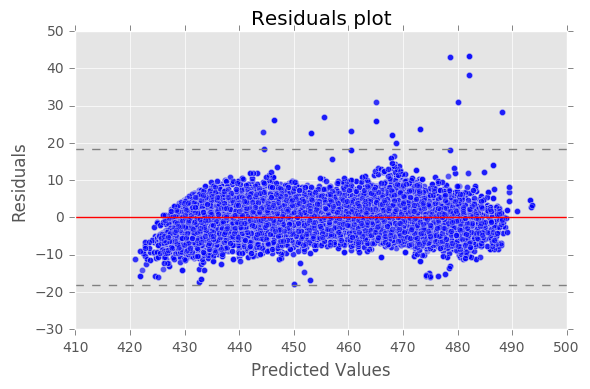

In [10]:
# Let's run predict using the train data for residual plot analysis:
predicted_y_train = pipeline.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_y_train))
resids = predicted_y_train.reshape(len(y_train), 1) - y_train

plt.clf()
plt.scatter(predicted_y_train, resids, alpha=0.4)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals plot')
plt.hlines(y=0, xmin=410, xmax=500, color='red')
plt.hlines(y=4 * resids.std(), xmin=410, xmax=500, color='gray', linestyles='--')  # a line to 4 standard deviations
plt.hlines(y=-4 * resids.std(), xmin=410, xmax=500, color='gray', linestyles='--') # a line to -4 standard deviations
plt.tight_layout()
plt.xlim([410, 500])
plt.show()

We do not see any big deviations from normality judging from the plot above. However, notice that for the Predicted Values at the extreme ends (between 420 and 430 as well as 480 and 490), the model seems to be under-predicting the target values more than over-predicting. 
In general, the residuals seem to be proportionately distributed around zero, so no big violation of constant variance (homoskedasticity). However, there are some outliers. Decision Tree models might be better suited for this data due to the presence of some non-linearity, as we'll see later.

We can plot a histogram to see the proportion of data within 2 RMSE, which should be around 95% for a normally distributed data:

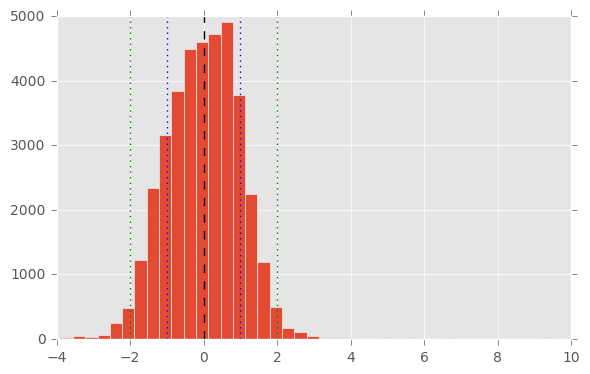

The proportion of test data predictions within 2 RMSE: 0.97


In [11]:
within_rmse = resids / rmse_train
plt.clf()
within_rmse.hist(bins=40)
plt.ylim([0, 5000])
plt.tight_layout()
plt.title('')
plt.vlines(0, ymin=0, ymax=4999, colors='k', linestyles='dashed')
plt.vlines(1, ymin=0, ymax=4999, colors='b', linestyles='dotted')
plt.vlines(-1, ymin=0, ymax=4999, colors='b', linestyles='dotted')
plt.vlines(2, ymin=0, ymax=4999, colors='g', linestyles='dotted')
plt.vlines(-2, ymin=0, ymax=4999, colors='g', linestyles='dotted')
plt.show()

count1 = within_rmse.where((within_rmse < -2) | (within_rmse > 2)).count()
print('The proportion of test data predictions within 2 RMSE: {:.2f}'.format((len(y_train) - int(count1)) / len(y_train)))

97% of the predicted values are within 2 RMSE. We can see some skewness on the graph. That was apparent from the presence of outliers in the previous graph.


Let's turn the two variables, AP and RH, that PE did not have any linear relationship with, into categorical variables. This can improve the performance of a linear regression model. We can bin the values into 10 bins:

In [12]:
bins_AP = np.linspace(X_train['AP'].min(), X_train['AP'].max(), 11)  # equidistant bounds used later for binning values 
bins_RH = np.linspace(X_train['RH'].min(), X_train['RH'].max(), 11)
bins_AP[0] = int(bins_AP[0])  # round the lowest value down, makes it easier when assigning values to bins
bins_RH[0] = int(bins_RH[0])  # same here
print(bins_AP)
print(bins_RH)

[  992.      996.931  1000.972  1005.013  1009.054  1013.095  1017.136
  1021.177  1025.218  1029.259  1033.3  ]
[  25.     33.02   40.48   47.94   55.4    62.86   70.32   77.78   85.24
   92.7   100.16]


In [13]:
which_bin_AP = np.digitize(X_train['AP'], bins=bins_AP, right=1)  # indices of bins to which each value in AP belongs.
which_bin_RH = np.digitize(X_train['RH'], bins=bins_RH, right=1)  # indices of bins to which each value in RH belongs.

encoder = OneHotEncoder(sparse=False)
Xtrain_AP_binned = encoder.fit_transform(which_bin_AP.reshape(-1, 1))  # find unique values that appear in which_bin
Xtrain_RH_binned = encoder.fit_transform(which_bin_RH.reshape(-1, 1))  # and transform the variables into categorical

# Number of observations per bin:
print(Xtrain_AP_binned.sum(axis=0)) 
print(Xtrain_RH_binned.sum(axis=0))

[    66.    399.   2218.   6791.  10153.   8888.   6368.   2248.    839.
    302.]
[  118.   551.  1626.  2790.  4247.  5800.  6818.  7260.  6279.  2783.]


Let's convert the ndarrays into dataframes with proper column names and print them out:

In [14]:
# Convert into dataframe objects
cols_AP = ['AP_' + str(bincount) for bincount in range(1, 11)]  # column names for AP
cols_RH = ['RH_' + str(bincount) for bincount in range(1, 11)]  # columns names for RH
Xtrain_AP_binned = pd.DataFrame(Xtrain_AP_binned, columns=cols_AP) 
Xtrain_RH_binned = pd.DataFrame(Xtrain_RH_binned, columns=cols_RH)
# check it out visually
for x in [Xtrain_AP_binned, Xtrain_RH_binned]:
    print(x.shape)
    print(x.head())

(38272, 10)
   AP_1  AP_2  AP_3  AP_4  AP_5  AP_6  AP_7  AP_8  AP_9  AP_10
0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0    0.0
1   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0    0.0
2   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0    0.0
3   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0    0.0
4   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0    0.0
(38272, 10)
   RH_1  RH_2  RH_3  RH_4  RH_5  RH_6  RH_7  RH_8  RH_9  RH_10
0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0    0.0
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0    0.0
2   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0    0.0
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0    0.0
4   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0    0.0


Now we can combine them with the original dataframe and from the continuous versions of the AP and RH variables:

In [15]:
X_train_binned = pd.concat([X_train.reset_index(), Xtrain_AP_binned, Xtrain_RH_binned], ignore_index=0, axis=1)

X_train_binned.drop(['index', 'AP', 'RH'], inplace=1, axis=1)
X_train_binned.head()

,AT,V,AP_1,AP_2,AP_3,AP_4,AP_5,AP_6,AP_7,AP_8,...,RH_1,RH_2,RH_3,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,RH_10
0,29.54,72.29,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.79,43.13,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,28.83,66.44,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,20.76,62.52,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,26.60,61.41,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
pipeline_binned = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipeline_binned.fit(X_train_binned, y_train)

# 10-fold cross-validated RMSE, R-Squared and Adjusted R-Squared:
rmse_cv_binned = np.sqrt(abs(cross_val_score(pipeline_binned, X_train_binned, y_train,
                                   scoring='neg_mean_squared_error', cv=10)) )
r2_cv_binned = cross_val_score(pipeline_binned, X_train_binned, y_train, scoring='r2', cv=10)
adj_r2_cv_binned = adjusted_r2(r2=r2_cv_binned.mean(), n=X_train_binned.shape[0] / 10, p=X_train_binned.shape[1])

# Since the cross_val_score above does a 10 fold cross-validation and returns
# a list of 10 RMSE and R-squared values, I take the mean of those and print out below:
print('The mean cross-validated RMSE and its standard deviation are {:.3f} and {:.3f}'
      .format(rmse_cv_binned.mean(), rmse_cv_binned.std())) 
print('The mean cross-validated R-Squared value and its standard deviation are {:.3f} and {:.3f}'
      .format(r2_cv_binned.mean(), r2_cv_binned.std()))
print('The mean cross-validated Adjusted R-Squared value is {:.3f}'.format(adj_r2_cv_binned))

The mean cross-validated RMSE and its standard deviation are 4.560 and 0.066
The mean cross-validated R-Squared value and its standard deviation are 0.929 and 0.002
The mean cross-validated Adjusted R-Squared value is 0.928


The 10 fold cross-validated RMSE score is slightly better now after binning the two variables. However, it's not a huge improvement. 

Now, let's run a Ridge Regression (regression with $l_2$-regularization) and a Lasso Regression ($l_1$-regularization) to compare their performance to the above model. These two models help us avoid overfitting the training data and have a better generalization potential. They require us to pre-specify a regularization parameter, `alpha`, which indicates the strength of the regularization. I use `GridSearchCV` from the `sklearn` module to do an exaustive search and find the best value of the parameter `alpha` for the model using 3 folds (for cross-validation) and 7 different options for the parameter value.

First, to make things easier, I define a function that will train a model and print out the model performance evaluation. I make use of nested cross-validation with 3 inner loops and 5 outer loops for model performance comparison. Nested cross-validation is advised as best practice for model performance comparison where we need to tune hyperparameters as well as compare different models. The inner loop finds the best parameters using cross-validated grid search and the outer loop evaluates the performance of the model with the best parameters. This gives a more reliable estimate of model performance on unseen data.

In [17]:
def nested_cv(estimator, param_names, param_vals=list(np.logspace(-4, 2, 7)), X_train=X_train, y_train=y_train):
    ''' Performs model performance evaluation (with RMSE) using a 5x3 nested cross-validation. 
        Inputs:
            estimator: estimator, model instance
            param_names: a list of hyperparameter names to be tuned by grid search
            param_vals: a list of hyperparameter values to use for tuning, default(list(np.logspace(-4, 2, 7)))
            y_train: the target variable. A DataFrame or ndarray object
        Returns:
            nested_cv_RMSE value: a float
    '''
    if not isinstance(param_vals[0], list):
        temp_pv = []
        temp_pv.append(param_vals)
    else:
        temp_pv = param_vals
    params = {name: val for name, val in zip(param_names, temp_pv)} 
    # inner loop:
    grid_search = GridSearchCV(estimator=estimator, param_grid=params,
                               scoring='neg_mean_squared_error', n_jobs=-1, cv=3)
    # outer loop:
    MSEs = cross_val_score(grid_search, X=X_train, y=y_train, n_jobs=-1, cv=5)
    nested_cv_RMSE = np.sqrt(-MSEs.mean())
    return nested_cv_RMSE

In [18]:
print('Ridge Regression:')
pipe_ridge = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(random_state=1))])
tune_param_ridge = ['ridge__alpha']

rmse_ncv_ridge = nested_cv(pipe_ridge, tune_param_ridge)
print('RMSE: {:.3f}'.format(rmse_ncv_ridge))

Ridge Regression:
RMSE: 4.573


In [19]:
print('Lasso Regression:')
pipe_lasso = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(random_state=2))])
tune_param_lasso = ['lasso__alpha']

rmse_ncv_lasso = nested_cv(pipe_lasso, tune_param_lasso)
print('RMSE: {:.3f}'.format(rmse_ncv_lasso))

Lasso Regression:
RMSE: 4.573


As we can see, the performance here is the same as the performance of the OLS model without any regularization. Both, the lasso and ridge regression perform equally with cross-validated lowest RMSE values of $4.573$. If we want to see the best parameters we'll have to do another grid search (just the inner loop of the nested-crossvalidation):


In [20]:
def tune_hyperparams(estimator, param_names, param_vals=list(np.logspace(-4, 2, 7)), X_train=X_train, y_train=y_train):
    ''' Performs a grid search to find the best hyperparameters for a model.
        Inputs:
            estimator: estimator, model instance
            param_names: a list of hyperparameter names to be tuned by grid search
            param_vals: a list of hyperparameter values to use for tuning, default(list(np.logspace(-4, 2, 7)))
            y_train: the target variable. A DataFrame or ndarray object
        Returns:
            nested_cv_RMSE value: a float
    '''
    if not isinstance(param_vals[0], list):
        temp_pv = []
        temp_pv.append(param_vals)
    else:
        temp_pv = param_vals
    params = {name: val for name, val in zip(param_names, temp_pv)}
    grid_search = GridSearchCV(estimator, params, scoring='neg_mean_squared_error',
                               n_jobs=-1, cv=3)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

In [21]:
best_params_ridge = tune_hyperparams(pipe_ridge, tune_param_ridge)
best_params_lasso = tune_hyperparams(pipe_lasso, tune_param_lasso)

print('Ridge Regression best hyperparameter: ', best_params_ridge)
print('Lasso Regression best hyperparameter: ', best_params_lasso)

Ridge Regression best hyperparameter:  {'ridge__alpha': 0.10000000000000001}
Lasso Regression best hyperparameter:  {'lasso__alpha': 0.0001}


Now with the binned AP and RH variables:

In [22]:
rmse_ncv_ridge_binned = nested_cv(pipe_ridge, tune_param_ridge, X_train=X_train_binned)
rmse_ncv_lasso_binned = nested_cv(pipe_lasso, tune_param_lasso, X_train=X_train_binned)

best_params_ridge_binned = tune_hyperparams(pipe_ridge, tune_param_ridge, X_train=X_train_binned)
best_params_lasso_binned = tune_hyperparams(pipe_lasso, tune_param_lasso, X_train=X_train_binned)

print('Ridge Regression:')
print('RMSE: {:.3f}'.format(rmse_ncv_ridge_binned))
print()
print('Lasso Regression:')
print('RMSE: {:.3f}'.format(rmse_ncv_lasso_binned))
print()
print('Ridge Regression best hyperparameter: ', best_params_ridge)
print('Lasso Regression best hyperparameter: ', best_params_lasso)

Ridge Regression:
RMSE: 4.561

Lasso Regression:
RMSE: 4.561

Ridge Regression best hyperparameter:  {'ridge__alpha': 0.10000000000000001}
Lasso Regression best hyperparameter:  {'lasso__alpha': 0.0001}


Again, with binned variables, the performance has improved marginally.

#### Decision Tree and Random Forest models

Since a Decision Tree model is better for non-linear data, let's see how it performs.
An advantage of Decision Tree models is that we don't need to transform the features, so no need for standardization here.

In [23]:
dt = DecisionTreeRegressor(random_state=0, max_depth=3)
score = np.sqrt(-cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error', cv=10))
print('Decision Tree model:')
print('RMSE: {:.3f}'.format(score.mean()))

Decision Tree model:
RMSE: 5.125


Compared to RMSE's of OSL, Ridge and Lasso regression models $(4.573$, $4.573$ and $4.573)$ the Decision Tree model above has a worse performance.

We can visualize the tree using the `export_graphviz()` function imported from the `sklearn.tree` module to save a `.dot` file and then convert it to `.png` using `dot -Tpng dt.dot -o dt.png` in the command line in the directory where the file is saved.

In [24]:
dt.fit(X_train, y_train)
export_graphviz(dt, out_file="dt.dot", feature_names=X_train.columns, filled=1, rotate=1)

![Decision Tree Graph](./dt.png)

We see that mostly the $AT$ feature is used to split the tree into child nodes. At two of the nodes, the model is using the $V$ feature. This is not surprising and fits the impression we got from the scatter plots shown earlier that only these two variables seem to have a linear relationsihp with __Power Output__. 
We can plot the feature importances using the `feature_importances_` attribute of tree based models in `sklearn`:

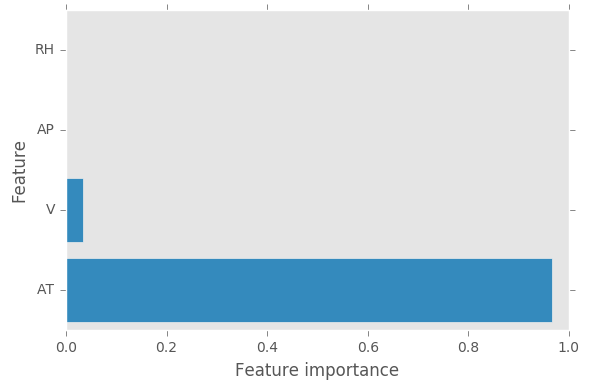

In [25]:
def feature_importances(model):
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.grid()
    plt.show()

feature_importances(dt)

This graph confirms our conclusion above. $AT$ is the star in this movie.

The model has a max depth of 3, as we can see from it's graphical representation. Let's try to tune the maximum depth of the tree using the `nested_cv()` function I defined earlier. Below I try the values 3, 9 and 15 as the `max_depth` parameter value and print out the RMSE:

In [26]:
print('Decision Tree model (nested CV):')
dt = DecisionTreeRegressor(random_state=0)
tune_param_dt = ['max_depth']
param_vals_dt = [3, 9, 15]

rmse_ncv_dt = nested_cv(dt, tune_param_dt, param_vals_dt)
print('RMSE: {:.3f}'.format(rmse_ncv_dt))

Decision Tree model (nested CV):
RMSE: 1.562


So, a tuned Decision Tree model performs much better than the Linear Regression models before it.
Let's see the what `max_depth` value gives the best performance:

In [27]:
best_params_dt = tune_hyperparams(dt, tune_param_dt, param_vals_dt)
print('Decision Tree best hyperparameter: ', best_params_dt)

Decision Tree best hyperparameter:  {'max_depth': 15}


Looks like a tree with maximum depth of 15 will give a better performance. A Decision Tree model will tend to perform better the deeper it is and will, thus, overfit the training data and might not perform so well with unseen data (this is also called a high variance problem).

We can try a Random Forest model instead, which is an ensemble of Decision Tree models and as such has better generalization potential.

In [28]:
forest = RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=1,
                               warm_start=1, oob_score=1)
score = np.sqrt(-cross_val_score(forest, X_train, y_train.values.ravel(), scoring='neg_mean_squared_error', cv=5))
print('Random Forest Model:')
print('RMSE: {:.3f}'.format(score.mean()))

forest.fit(X_train, y_train.values.ravel())
predicted_y_test = forest.predict(X_test)

Random Forest Model:
RMSE: 0.676


With 30 decision trees in the ensemble, the Random Forest model is better than just a single Decision Tree.

Let's try to tune the `n_estimators` and `max_depth` parameters:

In [29]:
print('Random Forest model (nested CV):')
tune_param_forest = ['n_estimators', 'max_depth']
param_vals_forest = [[30, 60, 90, 150], [3, 6, 10, 20]]

rmse_ncv_forest = nested_cv(forest, tune_param_forest, param_vals_forest, y_train=y_train.values.ravel())
print('RMSE: {:.3f}'.format(rmse_ncv_forest))

Random Forest model (nested CV):
RMSE: 0.682


We can see that the tuned Random Forest model above performs slightly below the first version above with 30 trees (and unrestricted depth for each tree). This model's performance was probably hindered by the restriction on the `max_depth`parameter, which we specified to be either of 3, 6, 10 or 20.  

Let's see the best hyperparameter values and how the model performs on the unseen test set:

In [30]:
params = {name: val for name, val in zip(tune_param_forest, param_vals_forest)}
grid_search = GridSearchCV(forest, params, scoring='neg_mean_squared_error',
                           n_jobs=-1, cv=3)
grid_search.fit(X_train, y_train.values.ravel())
predicted_y_test = grid_search.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, predicted_y_test))
r2_test = r2_score(y_test, predicted_y_test)
adj_r2_test = adjusted_r2(r2=r2_test, n=X_test.shape[0], p=X_test.shape[1])

print('Decision Tree best hyperparameters: ', grid_search.best_params_)
print('\n', 'Model performance on unseen data:')
print('The test dataset RMSE is: {:.3f}'.format(rmse_test))
print('The test dataset R-Squared value is: {:.3f}'.format(r2_test))
print('The test dataset Adjusted R-Squared value is {:.3f}'.format(adj_r2_test))

Decision Tree best hyperparameters:  {'n_estimators': 150, 'max_depth': 20}

 Model performance on unseen data:
The test dataset RMSE is: 0.376
The test dataset R-Squared value is: 1.000
The test dataset Adjusted R-Squared value is 1.000


The performance of this model on the unseen test data is good, with R-Squared values of almost $1.000$ and test dataset RMSE value almost half of the RMSE value for the training dataset.

We can plot the feature importances as judged by the Random Forest model:

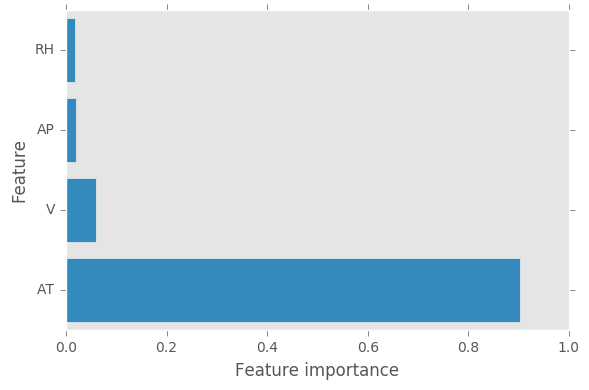

In [31]:
feature_importances(grid_search.best_estimator_)

Unsurprisingly, __Atmospheric Temperature__ is the most important feature, outshining the other features by quite a lot. 

### Conclusion

So, the best model we've seen is the Random Forest model, with the lowest nested cross-validated RMSE as we can see in the table below:

In [32]:
print('Model          ', 'RMSE')
print('                training set')
print('-' * 25)
print('OLS            ', '{:.4f}'.format(rmse_cv.mean()))
print('Ridge          ', '{:.5f}'.format(rmse_ncv_ridge))
print('Lasso          ', '{:.5f}'.format(rmse_ncv_lasso))
print('Decision Tree  ', '{:.4f}'.format(rmse_ncv_dt))
print('Random Forest  ', '{:.4f}'.format(rmse_ncv_forest))

Model           RMSE
                training set
-------------------------
OLS             4.5725
Ridge           4.57320
Lasso           4.57319
Decision Tree   1.5622
Random Forest   0.6821


The performance of the Random Forest model was slightly better when faced with unseen test data:

In [33]:
print('Random Forest RMSE (test dataset) {:.4f}'.format(rmse_test))

Random Forest RMSE (test dataset) 0.3762
